In [185]:
import random

REWARD_CLICK = 1
REWARD_NO_CLICK = 0


class WebsiteEnvironmentSimple:
    def __init__(self, proba):
        self.proba = proba

    def do(self, action):
        reward = REWARD_CLICK if random.random() < self.proba[action] else REWARD_NO_CLICK
        return reward

In [186]:
from abc import ABC, abstractmethod


class BanditBase(ABC):
    def __init__(self, K, env):
        self.arms = list(range(K))
        self.env = env
        self.history = []

    @abstractmethod
    def get_action(self):
        raise NotImplementedError()

    def update(self, arm, reward):
        self.history.append([arm, reward])
        self._update(arm, reward)

    @abstractmethod
    def _update(self, arm, reward):
        raise NotImplementedError()


In [187]:
import numpy as np
import math
from abc import abstractmethod

class UGapEBandit(BanditBase):
    def __init__(self, ϵ, m, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ϵ = ϵ
        self.m = m

        self.rewards = {arm: [] for arm in self.arms}

    def compute_round_parameters(self):
        betas = []
        lower_bounds = []
        upper_bounds = []
        regret_bounds = []

        for arm in self.arms:
            arm_beta = self.get_arm_beta(arm)
            betas.append(arm_beta)
            lower_bounds.append(self._compute_mean_reward(arm) - arm_beta)
            upper_bounds.append(self._compute_mean_reward(arm) + arm_beta)

        for k in set(self.arms):
            values = []
            for i in set(self.arms) - {arm}:
                values.append(upper_bounds[i] - lower_bounds[k])
            regret_bounds.append(max(values))

        return regret_bounds, lower_bounds, upper_bounds, betas

    def get_action(self):
        # Makes sure we have played every arm at least once
        for arm, rewards in self.rewards.items():
            if len(rewards) == 0:
                return arm

        B_t, L_t, U_t, β_t = self.compute_round_parameters()
        J_t = np.argsort(B_t)[:self.m]
        u_t, l_t = self._compute_u_t(J_t, U_t), self._compute_l_t(J_t, L_t)
        arm = u_t if β_t[u_t] > β_t[l_t] else l_t
        return arm

    @abstractmethod
    def get_arm_beta(self, arm):
        raise NotImplementedError()

    def _update(self, arm, reward):
        self.rewards[arm].append(reward)

    def _compute_l_t(self, J_t, L_t):
        l_t, l_t_value = None, None
        for arm in J_t:
            if not l_t_value or L_t[arm] > l_t_value:
                l_t = arm
                l_t_value = L_t[arm]
        return l_t

    def _compute_u_t(self, J_t, U_t):
        u_t, u_t_value = None, None
        for arm in set(self.arms) - set(J_t):
            if not u_t_value or U_t[arm] > u_t_value:
                u_t = arm
                u_t_value = U_t[arm]
        return u_t
    
    def _compute_mean_reward(self, arm):
        return np.mean(self.rewards[arm])


class UGapEBudgetBandit(UGapEBandit):
    def __init__(self, ϵ, m, n, a, *args, **kwargs):
        super().__init__(ϵ=ϵ, m=m, *args, **kwargs)
        self.n = n
        self.a = a

    def get_arm_beta(self, arm):
        # TODO: In our case, b = 1. This could be dynamically set.
        return math.sqrt(self.a / len(self.rewards[arm]))


In [252]:
conversion_rates = [0.15, 0.12, 0.13, 0.11, 0.16, 0.135, 0.14]
env = WebsiteEnvironmentSimple(conversion_rates)

In [253]:
bandit = UGapEBudgetBandit(ϵ=0.9, m=1, K=len(conversion_rates), n=len(conversion_rates), a=1/2, env=env)

In [248]:
import random

import numpy as np


class EpsilonGreedyBandit(BanditBase):
    def __init__(self, ϵ, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ϵ = ϵ
        self.rewards = {arm: [] for arm in self.arms}

    def get_action(self):
        if random.random() < self.ϵ:
            action = random.choice(self.arms)
        else:
            action = np.argmax([np.mean(arm_rewards) for arm_rewards in self.rewards.values()])

        return action

    def _update(self, arm, reward):
        self.rewards[arm].append(reward)


In [251]:
bandit = EpsilonGreedyBandit(0.2, K=len(conversion_rates), env=env)

In [254]:
data = []
for _ in range(5_000):
    action = bandit.get_action()
    reward = env.do(action)
    data.append({
        'action': action,
        'reward': reward
    })
    bandit.update(action, reward)

In [255]:
import pandas as pd
data = pd.DataFrame(data)
data.groupby('action').count()

,reward
action,
0,2092
1,207
2,41
3,85
4,2093
5,358
6,124


In [256]:
t = 1
days = []
while len(days) < data.shape[0]:
    views = 1000
    if len(days) + views > data.shape[0]:
        views -= (len(days) + views) - data.shape[0]
    days = days + [t for _ in range(views)]
    t += 1

In [257]:
data['day'] = days

In [258]:
dff = data.groupby(['day', 'action']).count().reset_index()
dff[dff['day'] == 100]

,day,action,reward


In [259]:
data.groupby(['day', 'action']).count().reset_index()

,day,action,reward
0,1,0,289
1,1,1,178
2,1,2,35
3,1,3,60
4,1,4,105
5,1,5,289
6,1,6,44
7,2,0,374
8,2,1,11
9,2,2,3


In [260]:
dff = data \
    .groupby(['day', 'action']).count().reset_index() \
    .pivot(index='day', columns='action', values='reward') \
    .fillna(0) 
dff.head(5)

action,0,1,2,3,4,5,6
day,,,,,,,
1,289.0,178.0,35.0,60.0,105.0,289.0,44.0
2,374.0,11.0,3.0,20.0,558.0,31.0,3.0
3,500.0,0.0,0.0,0.0,500.0,0.0,0.0
4,498.0,1.0,1.0,0.0,499.0,1.0,0.0
5,431.0,17.0,2.0,5.0,431.0,37.0,77.0


<AxesSubplot:xlabel='day'>

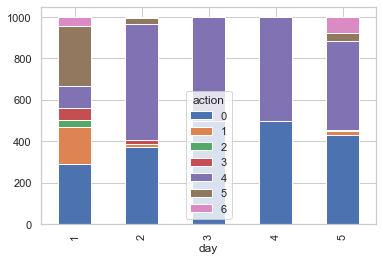

In [261]:
dff.plot(kind='bar', stacked=True)

In [267]:
bandit._compute_mean_reward(4)

0.15671285236502627

In [262]:
bandit.compute_round_parameters()

([0.04135726889473118,
  0.11020517666559386,
  0.23382000732837444,
  0.1665125267666724,
  0.030912233386759302,
  0.08663569576304184,
  0.13889483901011407],
 [0.13081170016367474,
  0.061963792392812064,
  -0.0616510382699685,
  0.005656442291733538,
  0.14125673567164662,
  0.08553327329536409,
  0.03327413004829184],
 [0.16173132086883005,
  0.16025842982941013,
  0.1592120138797246,
  0.15904944006120764,
  0.17216896905840592,
  0.1602767825705577,
  0.16027425704848236],
 [0.015459810352577657,
  0.04914731871829904,
  0.11043152607484655,
  0.07669649888473705,
  0.015456116693379658,
  0.037371754637596795,
  0.06350006350009525])

Kinda weird \
Is this what it means to do best arm identification instead of regret minimization? If so, do website designers really want this?